In [11]:
# Cell 1: Import necessary libraries with visualization support
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

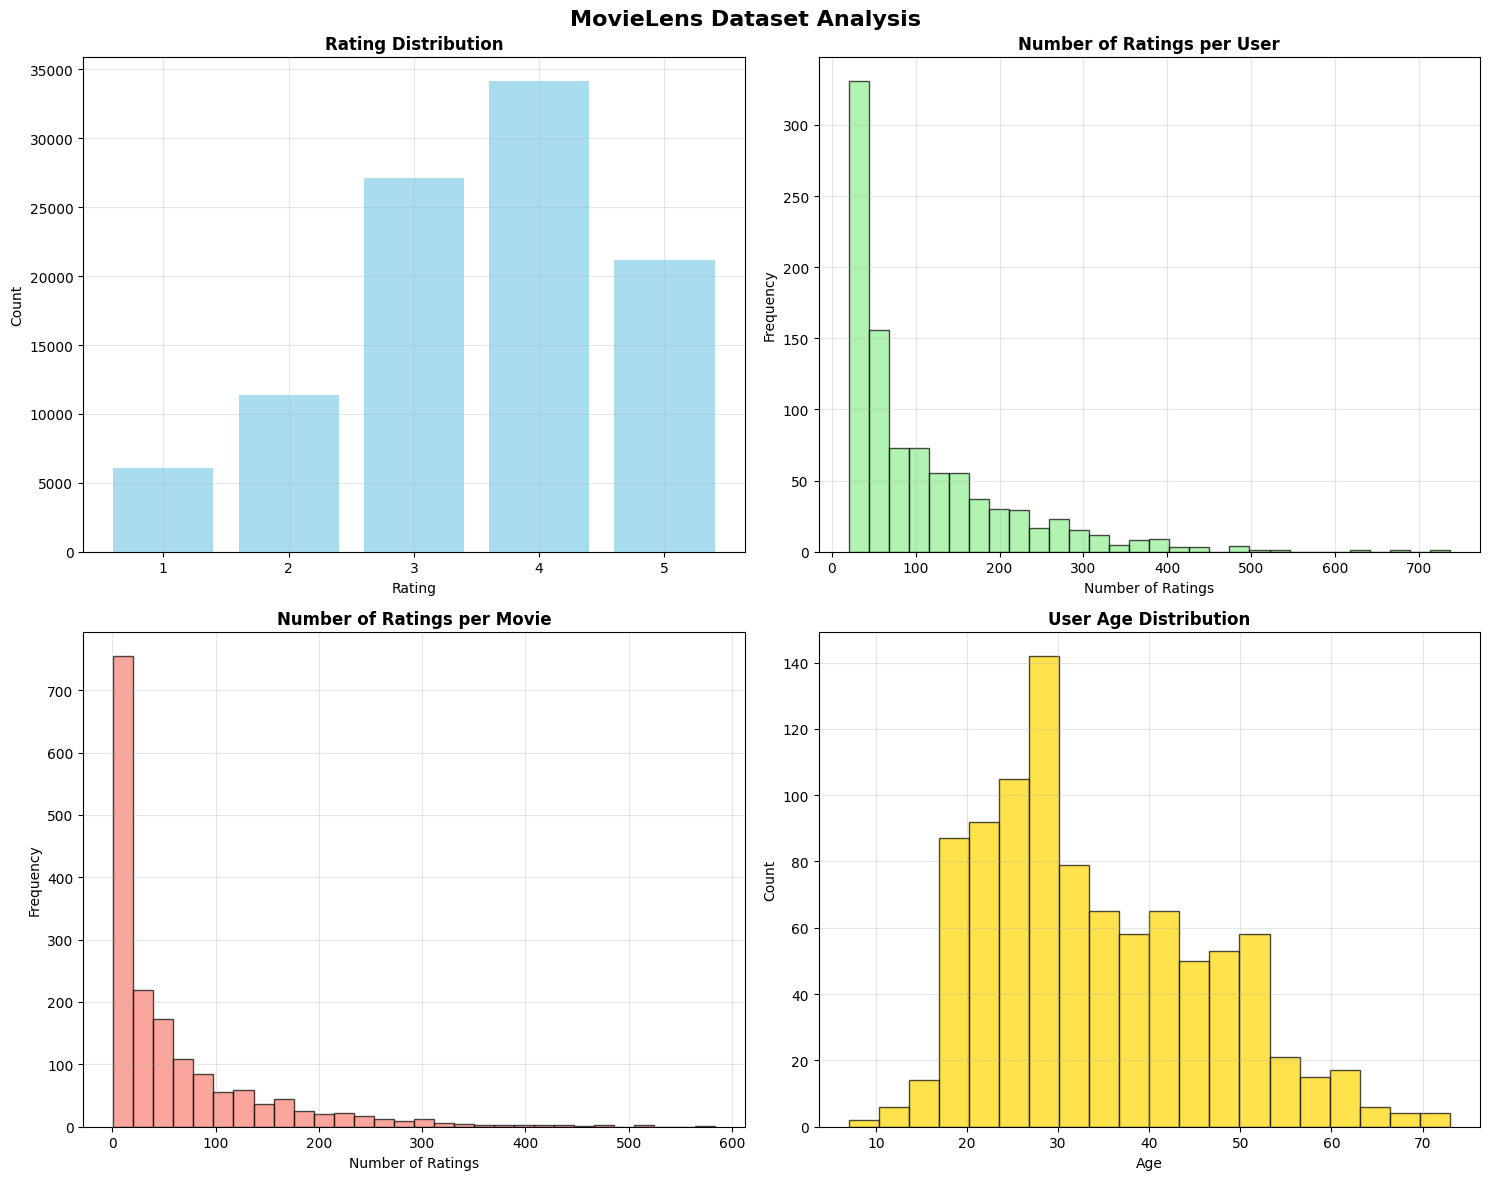

In [12]:
# Cell 2: Load and visualize dataset
def load_and_visualize_data():
    # Load data
    ratings = pd.read_csv(r'C:\Users\hp\Downloads\archive (1)\ml-100k\u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
    movies = pd.read_csv(r'C:\Users\hp\Downloads\archive (1)\ml-100k\u.item', sep='|', encoding='latin-1', 
                        names=['movie_id', 'title', 'release_date', 'video_release_date', 
                              'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                              'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                              'Thriller', 'War', 'Western'])
    users = pd.read_csv(r'C:\Users\hp\Downloads\archive (1)\ml-100k\u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('MovieLens Dataset Analysis', fontsize=16, fontweight='bold')
    
    # Rating distribution
    rating_counts = ratings['rating'].value_counts().sort_index()
    axes[0,0].bar(rating_counts.index, rating_counts.values, color='skyblue', alpha=0.7)
    axes[0,0].set_title('Rating Distribution', fontweight='bold')
    axes[0,0].set_xlabel('Rating')
    axes[0,0].set_ylabel('Count')
    axes[0,0].grid(True, alpha=0.3)
    
    # User rating count distribution
    user_rating_counts = ratings['user_id'].value_counts()
    axes[0,1].hist(user_rating_counts.values, bins=30, color='lightgreen', alpha=0.7, edgecolor='black')
    axes[0,1].set_title('Number of Ratings per User', fontweight='bold')
    axes[0,1].set_xlabel('Number of Ratings')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].grid(True, alpha=0.3)
    
    # Movie rating count distribution
    movie_rating_counts = ratings['movie_id'].value_counts()
    axes[1,0].hist(movie_rating_counts.values, bins=30, color='salmon', alpha=0.7, edgecolor='black')
    axes[1,0].set_title('Number of Ratings per Movie', fontweight='bold')
    axes[1,0].set_xlabel('Number of Ratings')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].grid(True, alpha=0.3)
    
    # User demographics - Age distribution
    axes[1,1].hist(users['age'], bins=20, color='gold', alpha=0.7, edgecolor='black')
    axes[1,1].set_title('User Age Distribution', fontweight='bold')
    axes[1,1].set_xlabel('Age')
    axes[1,1].set_ylabel('Count')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return ratings, movies, users

ratings, movies, users = load_and_visualize_data()

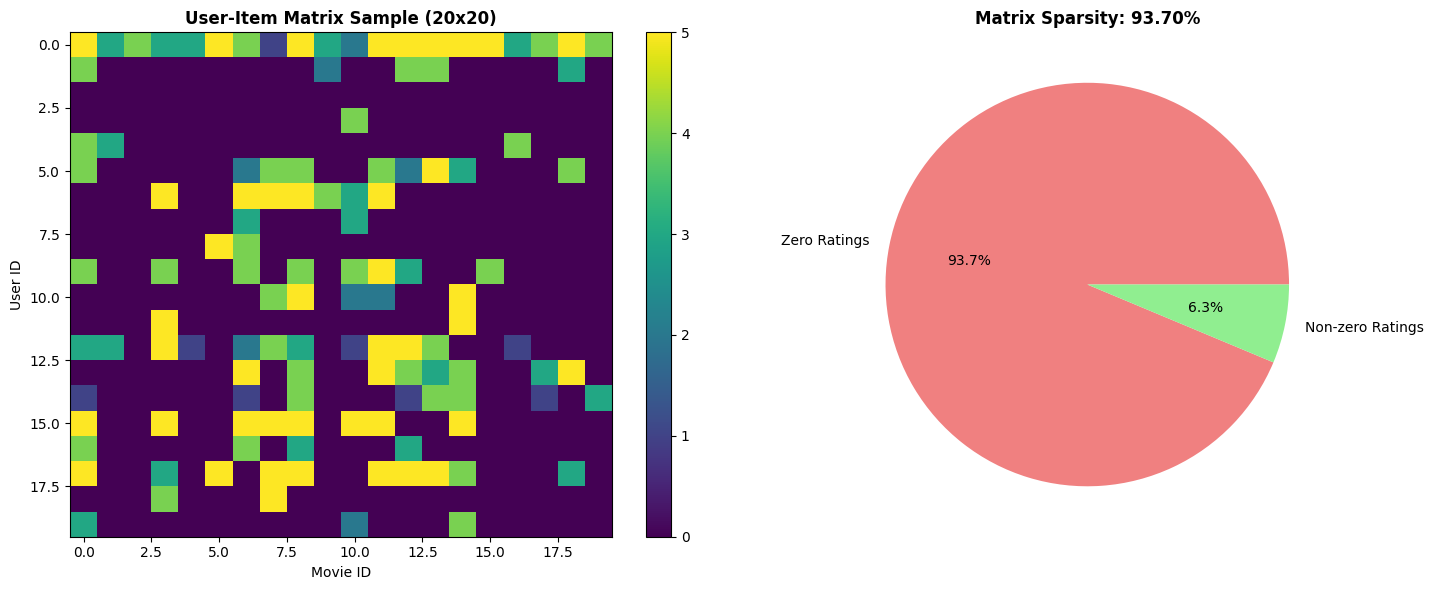

Matrix Shape: (943, 1682)
Sparsity: 93.70%


In [13]:
# Cell 3: Create and visualize user-item matrix
def create_and_visualize_matrix(ratings):
    # Create user-item matrix
    user_item_matrix = ratings.pivot_table(
        index='user_id', 
        columns='movie_id', 
        values='rating', 
        fill_value=0
    )
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Sparsity heatmap (sample)
    sample_matrix = user_item_matrix.iloc[:20, :20]
    im = axes[0].imshow(sample_matrix, cmap='viridis', aspect='auto')
    axes[0].set_title('User-Item Matrix Sample (20x20)', fontweight='bold')
    axes[0].set_xlabel('Movie ID')
    axes[0].set_ylabel('User ID')
    plt.colorbar(im, ax=axes[0])
    
    # Sparsity analysis
    sparsity = (user_item_matrix == 0).sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1])
    axes[1].pie([sparsity, 1-sparsity], labels=['Zero Ratings', 'Non-zero Ratings'], 
                autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
    axes[1].set_title(f'Matrix Sparsity: {sparsity:.2%}', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Matrix Shape: {user_item_matrix.shape}")
    print(f"Sparsity: {sparsity:.2%}")
    
    return user_item_matrix

user_item_matrix = create_and_visualize_matrix(ratings)

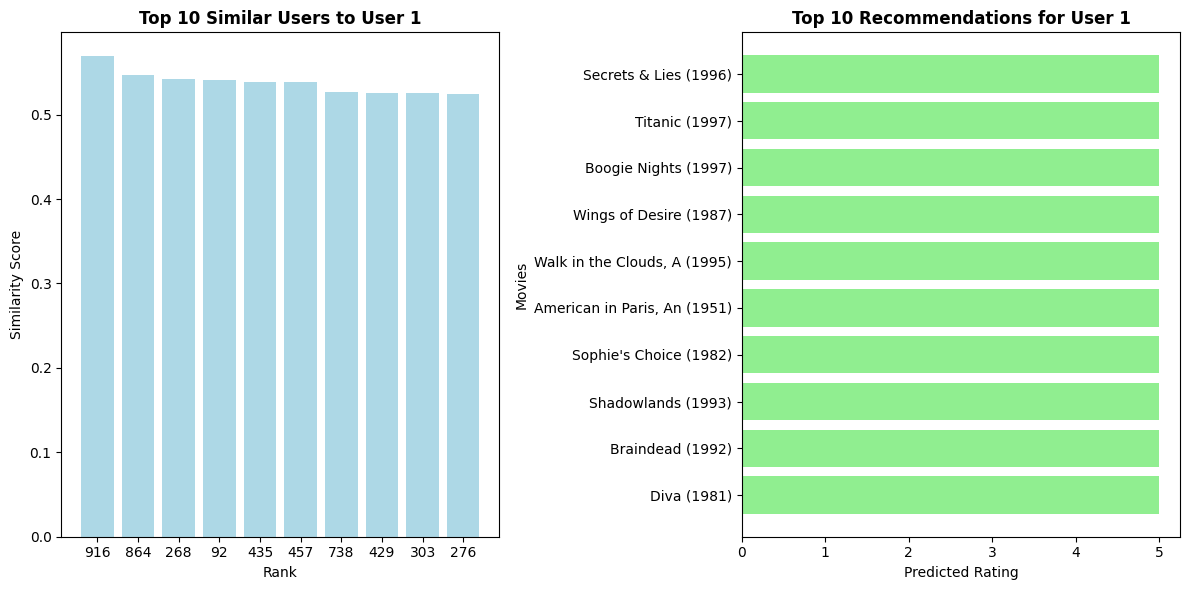

In [14]:
# Cell 4: User-based CF with visualizations
def user_based_recommendation_with_viz(user_id, user_item_matrix, movies, n_recommendations=10):
    # Compute user similarity
    user_similarity = cosine_similarity(user_item_matrix)
    user_similarity_df = pd.DataFrame(user_similarity, 
                                    index=user_item_matrix.index, 
                                    columns=user_item_matrix.index)
    
    # Get similar users
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:11]
    
    # Visualization: Similar users
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(len(similar_users)), similar_users.values, color='lightblue')
    plt.title(f'Top 10 Similar Users to User {user_id}', fontweight='bold')
    plt.xlabel('Rank')
    plt.ylabel('Similarity Score')
    plt.xticks(range(len(similar_users)), similar_users.index)
    
    # Generate recommendations
    target_user_ratings = user_item_matrix.loc[user_id]
    unseen_movies = target_user_ratings[target_user_ratings == 0].index
    
    recommendations = {}
    for movie_id in unseen_movies:
        weighted_sum = 0
        similarity_sum = 0
        for similar_user_id, similarity in similar_users.items():
            rating = user_item_matrix.loc[similar_user_id, movie_id]
            if rating > 0:
                weighted_sum += similarity * rating
                similarity_sum += similarity
        if similarity_sum > 0:
            recommendations[movie_id] = weighted_sum / similarity_sum
    
    top_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)[:n_recommendations]
    
    # Convert to movie titles
    recommended_movies = []
    for movie_id, score in top_recommendations:
        movie_title = movies[movies['movie_id'] == movie_id]['title'].values[0]
        recommended_movies.append((movie_title, score))
    
    # Visualization: Top recommendations
    plt.subplot(1, 2, 2)
    movie_titles = [movie[:30] + '...' if len(movie) > 30 else movie for movie, _ in recommended_movies]
    scores = [score for _, score in recommended_movies]
    plt.barh(range(len(scores)), scores, color='lightgreen')
    plt.title(f'Top {n_recommendations} Recommendations for User {user_id}', fontweight='bold')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Movies')
    plt.yticks(range(len(movie_titles)), movie_titles)
    plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    return recommended_movies, similar_users

# Test with visualization
user_id = 1
user_based_recs, similar_users = user_based_recommendation_with_viz(user_id, user_item_matrix, movies)

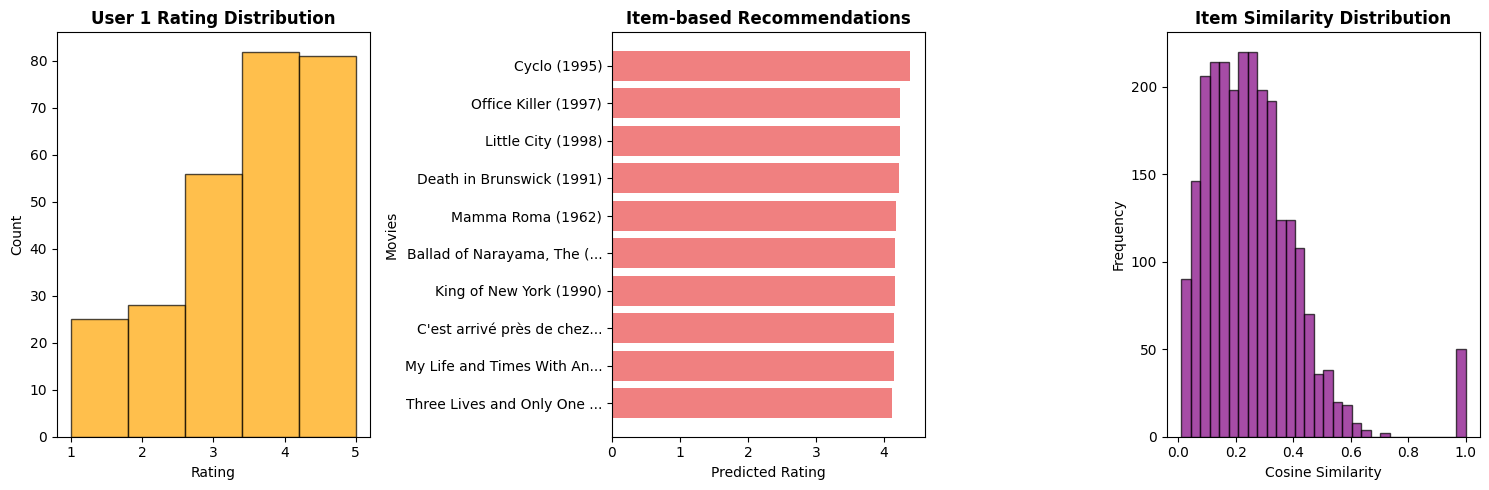

In [15]:
# Cell 5: Item-based CF with visualizations
def item_based_recommendation_with_viz(user_id, user_item_matrix, movies, n_recommendations=10):
    # Compute item similarity
    item_similarity = cosine_similarity(user_item_matrix.T)
    item_similarity_df = pd.DataFrame(item_similarity, 
                                    index=user_item_matrix.columns, 
                                    columns=user_item_matrix.columns)
    
    # Get user's rated movies
    user_ratings = user_item_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0].index
    
    # Visualization: User's rated movies
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    rated_scores = user_ratings[rated_movies].values
    plt.hist(rated_scores, bins=5, color='orange', alpha=0.7, edgecolor='black')
    plt.title(f'User {user_id} Rating Distribution', fontweight='bold')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    
    # Generate recommendations
    predictions = {}
    for movie_id in user_item_matrix.columns:
        if user_ratings[movie_id] == 0:
            numerator = 0
            denominator = 0
            for rated_movie in rated_movies:
                similarity = item_similarity_df.loc[movie_id, rated_movie]
                numerator += similarity * user_ratings[rated_movie]
                denominator += abs(similarity)
            if denominator > 0:
                predictions[movie_id] = numerator / denominator
    
    top_recommendations = sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:n_recommendations]
    
    # Convert to movie titles
    recommended_movies = []
    for movie_id, score in top_recommendations:
        movie_title = movies[movies['movie_id'] == movie_id]['title'].values[0]
        recommended_movies.append((movie_title, score))
    
    # Visualization: Top recommendations
    plt.subplot(1, 3, 2)
    movie_titles = [movie[:25] + '...' if len(movie) > 25 else movie for movie, _ in recommended_movies]
    scores = [score for _, score in recommended_movies]
    plt.barh(range(len(scores)), scores, color='lightcoral')
    plt.title(f'Item-based Recommendations', fontweight='bold')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Movies')
    plt.yticks(range(len(movie_titles)), movie_titles)
    plt.gca().invert_yaxis()
    
    # Visualization: Similarity distribution
    plt.subplot(1, 3, 3)
    sample_similarities = item_similarity_df.iloc[:50, :50].values.flatten()
    plt.hist(sample_similarities, bins=30, color='purple', alpha=0.7, edgecolor='black')
    plt.title('Item Similarity Distribution', fontweight='bold')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    return recommended_movies

# Test with visualization
item_based_recs = item_based_recommendation_with_viz(user_id, user_item_matrix, movies)

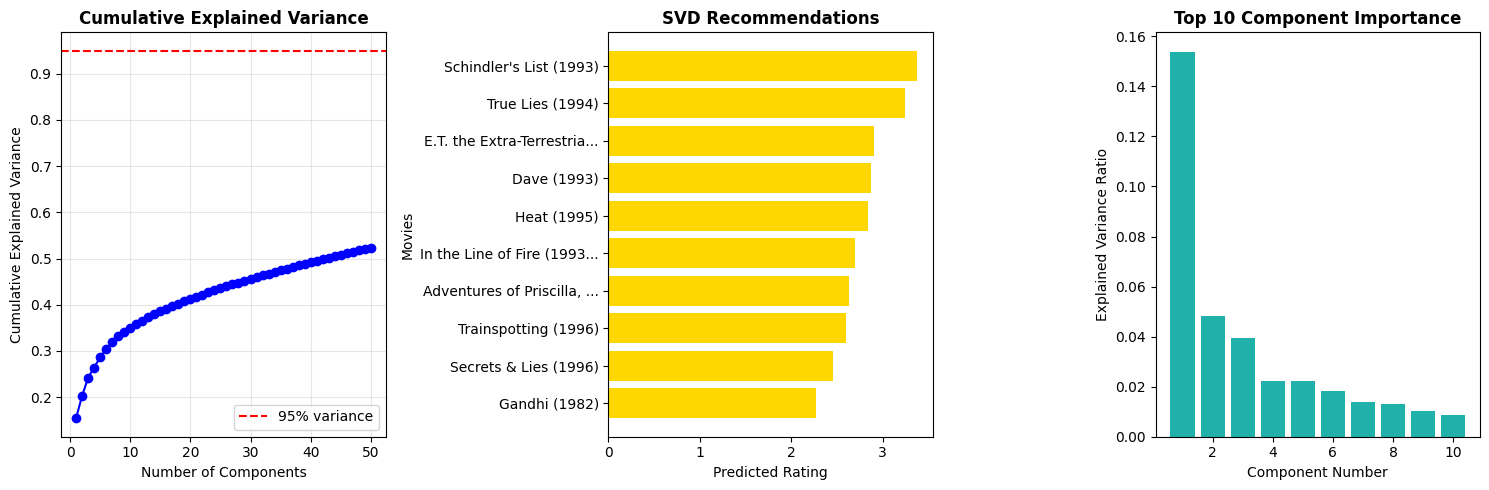

Total explained variance: 0.524


In [23]:
# Cell 6: SVD with comprehensive visualizations
def svd_recommendation_with_viz(user_id, user_item_matrix, movies, n_recommendations=10, n_components=50):
    # Convert to sparse matrix and perform SVD
    sparse_matrix = csr_matrix(user_item_matrix.values)
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    user_factors = svd.fit_transform(sparse_matrix)
    item_factors = svd.components_.T
    
    # Visualization: Explained variance
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    cumulative_variance = np.cumsum(svd.explained_variance_ratio_)
    plt.plot(range(1, n_components + 1), cumulative_variance, 'b-', marker='o')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
    plt.title('Cumulative Explained Variance', fontweight='bold')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Reconstruct matrix and get recommendations
    reconstructed_matrix = np.dot(user_factors, item_factors.T)
    reconstructed_df = pd.DataFrame(reconstructed_matrix, 
                                  index=user_item_matrix.index, 
                                  columns=user_item_matrix.columns)
    
    user_predictions = reconstructed_df.loc[user_id]
    user_ratings = user_item_matrix.loc[user_id]
    unseen_movies = user_ratings[user_ratings == 0].index
    
    predictions = user_predictions[unseen_movies]
    top_recommendations = predictions.sort_values(ascending=False)[:n_recommendations]
    
    # Convert to movie titles
    recommended_movies = []
    for movie_id, score in top_recommendations.items():
        movie_title = movies[movies['movie_id'] == movie_id]['title'].values[0]
        recommended_movies.append((movie_title, score))
    
    # Visualization: Top recommendations
    plt.subplot(1, 3, 2)
    movie_titles = [movie[:25] + '...' if len(movie) > 25 else movie for movie, _ in recommended_movies]
    scores = [score for _, score in recommended_movies]
    plt.barh(range(len(scores)), scores, color='gold')
    plt.title(f'SVD Recommendations', fontweight='bold')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Movies')
    plt.yticks(range(len(movie_titles)), movie_titles)
    plt.gca().invert_yaxis()
    
    # Visualization: Factor importance
    plt.subplot(1, 3, 3)
    component_importance = svd.explained_variance_ratio_
    plt.bar(range(1, 11), component_importance[:10], color='lightseagreen')
    plt.title('Top 10 Component Importance', fontweight='bold')
    plt.xlabel('Component Number')
    plt.ylabel('Explained Variance Ratio')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Total explained variance: {cumulative_variance[-1]:.3f}")
    
    return recommended_movies

# Test SVD with visualization
svd_recs = svd_recommendation_with_viz(user_id, user_item_matrix, movies)

In [27]:
# Evaluation: Precision@K
def evaluate_precision_at_k(recommendations, user_id, user_item_matrix, k=10):
    """
    Evaluate Precision@K for recommendations.

    Parameters:
    - recommendations: list of (movie, score) tuples from recommender
    - user_id: the target user ID
    - user_item_matrix: full user-item rating matrix
    - k: number of top recommendations to evaluate

    Returns:
    - precision_at_k (float)
    """
    # Top-k recommendations
    top_k = [movie for movie, _ in recommendations[:k]]

    # Movies that the user actually rated highly (ground truth relevant items)
    user_ratings = user_item_matrix.loc[user_id]
    relevant_items = set(user_ratings[user_ratings >= 4].dropna().index)

    # Intersection of recommended and relevant
    hits = len(set(top_k) & relevant_items)

    # Precision = hits / K
    return hits / k if k > 0 else 0.0


Generating user-based recommendations for user 1...
Top similar users: [916, 864, 268, 92, 435, 457, 738, 429, 303, 276]
Generating item-based recommendations for user 1...
User 1 has rated 272 movies
Generating SVD recommendations for user 1...
Explained variance ratio: 0.524


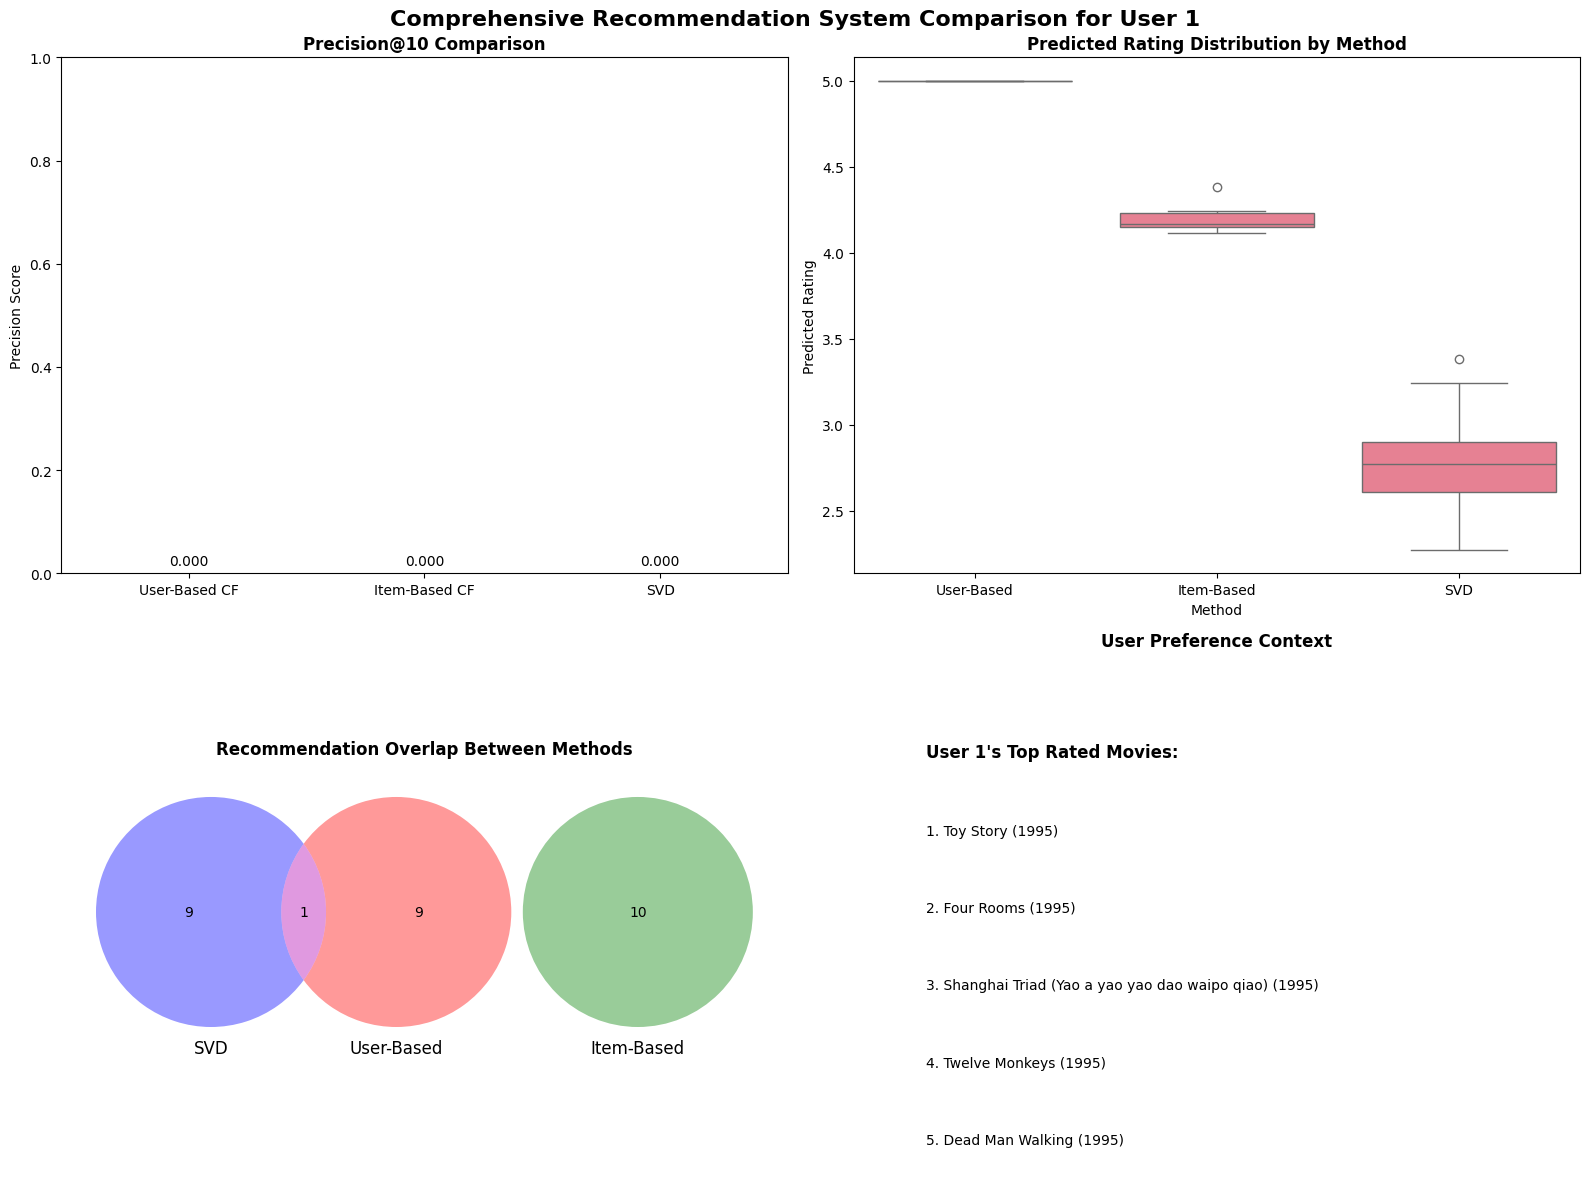

DETAILED COMPARISON RESULTS

Precision@10 Scores:
User-Based Collaborative Filtering: 0.000
Item-Based Collaborative Filtering: 0.000
Matrix Factorization (SVD): 0.000


In [33]:
# Cell 7: Comprehensive comparison with visualizations
def comprehensive_comparison(user_id, user_item_matrix, movies):
    # Generate all recommendations
    user_based_recs = user_based_recommendation(user_id, user_item_matrix, movies)
    item_based_recs = item_based_recommendation(user_id, user_item_matrix, movies)
    svd_recs = svd_recommendation(user_id, user_item_matrix, movies)
    
    # Evaluate precision (make sure these lines are indented!)
    precision_user = evaluate_precision_at_k(user_based_recs, user_id, user_item_matrix)
    precision_item = evaluate_precision_at_k(item_based_recs, user_id, user_item_matrix)
    precision_svd  = evaluate_precision_at_k(svd_recs, user_id, user_item_matrix)

    # Create comparison visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Comprehensive Recommendation System Comparison for User {user_id}', 
                fontsize=16, fontweight='bold')
    
    # Precision comparison
    methods = ['User-Based CF', 'Item-Based CF', 'SVD']
    precisions = [precision_user, precision_item, precision_svd]
    
    bars = axes[0,0].bar(methods, precisions, color=['lightblue', 'lightcoral', 'gold'])
    axes[0,0].set_title('Precision@10 Comparison', fontweight='bold')
    axes[0,0].set_ylabel('Precision Score')
    axes[0,0].set_ylim(0, 1)
    for bar, precision in zip(bars, precisions):
        axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                      f'{precision:.3f}', ha='center', va='bottom')
    
    # Predicted rating distribution
    all_scores = []
    labels = []
    for method_name, recs in [('User-Based', user_based_recs), 
                             ('Item-Based', item_based_recs), 
                             ('SVD', svd_recs)]:
        scores = [score for _, score in recs]
        all_scores.extend(scores)
        labels.extend([method_name] * len(scores))
    
    score_df = pd.DataFrame({'Method': labels, 'Predicted Rating': all_scores})
    sns.boxplot(data=score_df, x='Method', y='Predicted Rating', ax=axes[0,1])
    axes[0,1].set_title('Predicted Rating Distribution by Method', fontweight='bold')
    
    # Recommendation overlap
    methods_recs = {
        'User-Based': set([movie for movie, _ in user_based_recs]),
        'Item-Based': set([movie for movie, _ in item_based_recs]),
        'SVD': set([movie for movie, _ in svd_recs])
    }
    
    from matplotlib_venn import venn3
    venn3([methods_recs['User-Based'], methods_recs['Item-Based'], methods_recs['SVD']],
          set_labels=('User-Based', 'Item-Based', 'SVD'), ax=axes[1,0])
    axes[1,0].set_title('Recommendation Overlap Between Methods', fontweight='bold')
    
    # User's actual preferences
    user_ratings = user_item_matrix.loc[user_id]
    high_rated = user_ratings[user_ratings >= 4].index
    high_rated_movies = [movies[movies['movie_id'] == mid]['title'].values[0] for mid in high_rated[:5]]
     
    axes[1,1].text(0.1, 0.8, f"User {user_id}'s Top Rated Movies:", fontweight='bold', fontsize=12)
    for i, movie in enumerate(high_rated_movies, 1):
        axes[1,1].text(0.1, 0.8 - i*0.15, f"{i}. {movie}", fontsize=10)
    axes[1,1].axis('off')
    axes[1,1].set_title('User Preference Context', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("="*80)
    print("DETAILED COMPARISON RESULTS")
    print("="*80)
    print(f"\nPrecision@10 Scores:")
    print(f"User-Based Collaborative Filtering: {precision_user:.3f}")
    print(f"Item-Based Collaborative Filtering: {precision_item:.3f}")
    print(f"Matrix Factorization (SVD): {precision_svd:.3f}")
    
    return {
        'user_based': user_based_recs,
        'item_based': item_based_recs,
        'svd': svd_recs,
        'precisions': [precision_user, precision_item, precision_svd]
    }

# Run comprehensive comparison
results = comprehensive_comparison(user_id, user_item_matrix, movies)
